In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, RFECV
import scipy.stats as st
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [28]:
train = pd.read_csv('/content/drive/MyDrive/MLP Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/MLP Project/test.csv')
train = train[train.columns[1:]]
test = test[test.columns[1:]]
cols = test.columns

In [4]:
d = {'v_1': 'Binary',
'v_26': 'Binary',
'v_11': 'Binary',
'v_14': 'Binary',
'v_30': 'Binary', 'v_28': 'Binary', 'v_9': 'Binary', 'v_27': 'Binary',
'v_32': 'Nominal', 'v_4': 'Nominal',
'v_3': 'Nominal',
'v_20': 'Nominal',
'v_21': 'Nominal',
'v_18': 'Nominal',
'v_25': 'Nominal',
'v_12': 'Nominal', 'v_31': 'Ordinal',
'v_15': 'Ordinal',
'v_19': 'Ordinal',
'v_13': 'Ordinal',
'v_33': 'Ordinal',
'v_17': 'Ordinal',
'v_29': 'Ordinal',
'v_23': 'Ordinal',
'v_6': 'Ordinal', 'v_24': 'Ordinal', 'v_10': 'Ordinal', 'v_5': 'Ordinal',
'v_22': 'Ordinal', 'v_0': 'Ordinal',
'v_16': 'Ratio',
'v_2': 'Ratio',
'v_8': 'Ratio',
'v_7': 'Ratio' ,'v_34': 'Ratio', 'v_35': 'Ratio' ,'v_36': 'Ratio' ,'v_37': 'Ratio' ,'v_38': 'Ratio' ,'v_39': 'Ratio' ,'v_40': 'Ratio'}
types = list(set([value for key,value in d.items()]))
d = {k:[key for key,values in d.items() if values==k] for k in types}
numerical = d['Ratio']
nominal = d['Nominal']
ordinal = d['Ordinal']
binary = d['Binary']

In [30]:
X,Y = train.iloc[:,:-1], train.iloc[:,-1]
len(Y[Y==0]),len(Y[Y==1]),len(Y[Y==2]) 

(1243, 1863, 690)

In [31]:
X,Y = SMOTE(sampling_strategy='not majority',random_state=42).fit_resample(X,Y)
len(Y[Y==0]),len(Y[Y==1]),len(Y[Y==2]) 

(1863, 1863, 1863)

['v_31',
 'v_15',
 'v_19',
 'v_13',
 'v_33',
 'v_17',
 'v_29',
 'v_23',
 'v_6',
 'v_24',
 'v_10',
 'v_5',
 'v_22',
 'v_0']

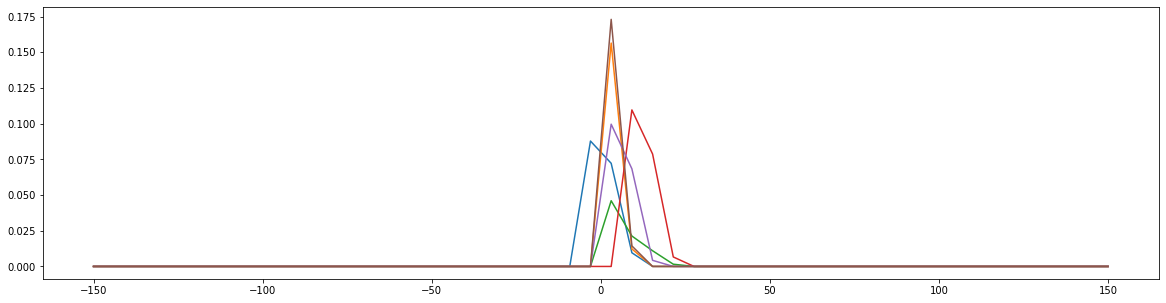

In [37]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
normal = []
for i in range(len(numerical)):
  x = X[numerical[i]]
  eval_points = np.linspace(-150, 150)
  kernel = st.gaussian_kde(x)
  y = kernel.pdf(eval_points)
  if np.max(y) < 0.04:
    continue
  normal.append(numerical[i])
  plt.plot(eval_points, y)
minmax = list(set(numerical) - set(normal)) 
ordinal

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

In [48]:
ct = ColumnTransformer([("normal", StandardScaler(), normal),
                        ("minmax", MinMaxScaler(), minmax),
                        ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal+nominal),
                        ("binary", 'passthrough', binary)])
le = LabelEncoder()
X_train_transformed = ct.fit_transform(X_train)
Y_train_transformed = le.fit_transform(Y_train)
X_test_transformed = ct.transform(X_test)
Y_test_transformed = le.transform(Y_test)

In [49]:
X_train_transformed.shape

(4471, 41)

In [10]:
def Testing(estimator, X_train, Y_train, X_test, Y_test):
  est = estimator.fit(X_train, Y_train)
  Y_pred = est.predict(X_test)
  score = f1_score(Y_test_transformed,est.predict(X_test_transformed), average='weighted')
  print(classification_report(Y_test_transformed,est.predict(X_test_transformed)))
  print(score)
  return score

In [11]:
def Validation(estimator, X, Y):
  v = []
  rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
  for train, test in rskf.split(X,Y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    Y_train, Y_test = Y.iloc[train], Y.iloc[test]
    X_train_transformed = ct.fit_transform(X_train)
    Y_train_transformed = le.fit_transform(Y_train)
    X_test_transformed = ct.transform(X_test)
    Y_test_transformed = le.transform(Y_test)
    estimator.fit(X_train_transformed, Y_train_transformed)
    v.append(f1_score(Y_test_transformed, estimator.predict(X_test_transformed),average='weighted'))
  return np.mean(np.asarray(v))

In [16]:
svc = SVC(kernel='rbf', C=500, random_state=42, probability=True, decision_function_shape='ovr')

In [17]:
Testing(svc, X_train_transformed, Y_train_transformed, X_test_transformed, Y_test_transformed)

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       372
           1       0.76      0.80      0.78       373
           2       0.75      0.73      0.74       373

    accuracy                           0.76      1118
   macro avg       0.76      0.76      0.76      1118
weighted avg       0.76      0.76      0.76      1118

0.7618818881733547


0.7618818881733547

In [18]:
Validation(svc,X,Y)

0.77055910887339

In [19]:
svc = SVC(random_state=42)
params = {'kernel':['poly','rbf'],'decision_function_shape':['ovr','ovo'], 
          'C':np.linspace(100,10000,num=900).astype(int),
          'degree':[3,4,5,6,7,8]}
rscv = RandomizedSearchCV(svc,params,scoring='f1_weighted',verbose=3,return_train_score=True, random_state=42, n_iter=100, cv=5)
rscv.fit(X_train_transformed, Y_train_transformed)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END C=7346, decision_function_shape=ovr, degree=4, kernel=rbf;, score=(train=0.975, test=0.794) total time=  15.3s
[CV 2/5] END C=7346, decision_function_shape=ovr, degree=4, kernel=rbf;, score=(train=0.974, test=0.758) total time=  14.0s
[CV 3/5] END C=7346, decision_function_shape=ovr, degree=4, kernel=rbf;, score=(train=0.976, test=0.760) total time=  14.8s
[CV 4/5] END C=7346, decision_function_shape=ovr, degree=4, kernel=rbf;, score=(train=0.973, test=0.760) total time=  15.2s
[CV 5/5] END C=7346, decision_function_shape=ovr, degree=4, kernel=rbf;, score=(train=0.972, test=0.785) total time=  13.6s
[CV 1/5] END C=485, decision_function_shape=ovo, degree=7, kernel=poly;, score=(train=0.897, test=0.699) total time=  14.5s
[CV 2/5] END C=485, decision_function_shape=ovo, degree=7, kernel=poly;, score=(train=0.903, test=0.713) total time=  16.8s
[CV 3/5] END C=485, decision_function_shape=ovo, degree=7, kernel=pol

RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_iter=100,
                   param_distributions={'C': array([  100,   111,   122,   133,   144,   155,   166,   177,   188,
         199,   210,   221,   232,   243,   254,   265,   276,   287,
         298,   309,   320,   331,   342,   353,   364,   375,   386,
         397,   408,   419,   430,   441,   452,   463,   474,   485,
         496,   507,   518,   529,   540,   551,   562,   573,   584,
         595,   606,   617,   628,   639,   650,   661,   672,   683,
         694,   705,   716,   727,   738,   749,   760,   771,   782,...
        9515,  9526,  9537,  9548,  9559,  9570,  9581,  9592,  9603,
        9614,  9625,  9636,  9647,  9658,  9669,  9680,  9691,  9702,
        9713,  9724,  9735,  9746,  9757,  9768,  9779,  9790,  9801,
        9812,  9823,  9834,  9845,  9856,  9867,  9878,  9889,  9900,
        9911,  9922,  9933,  9944,  9955,  9966,  9977,  9988, 10000]),
                                        '

In [20]:
rscv.best_params_

{'kernel': 'rbf', 'degree': 8, 'decision_function_shape': 'ovr', 'C': 1025}

In [23]:
bsvc = rscv.best_estimator_

In [24]:
bsvc

SVC(C=1025, degree=8, random_state=42)

In [22]:
Testing(bsvc, X_train_transformed, Y_train_transformed, X_test_transformed, Y_test_transformed)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       372
           1       0.77      0.78      0.77       373
           2       0.77      0.75      0.76       373

    accuracy                           0.77      1118
   macro avg       0.77      0.77      0.77      1118
weighted avg       0.77      0.77      0.77      1118

0.7718578596746237


0.7718578596746237